In [1]:


import numpy as np
import pandas as pd
import warnings
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

# Ignore warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('AMZN.csv')
df.head()

Date      Open      High       Low     Close  Adj Close      Volume
0  1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000
1  1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000
2  1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000
3  1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000
4  1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000

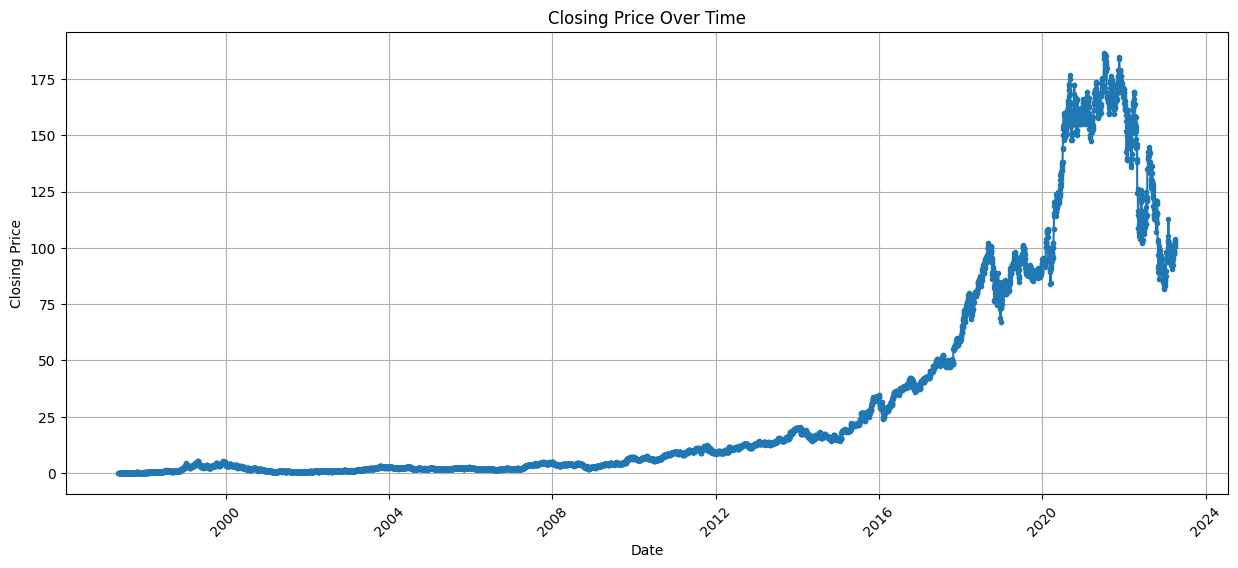

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'], marker='.')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


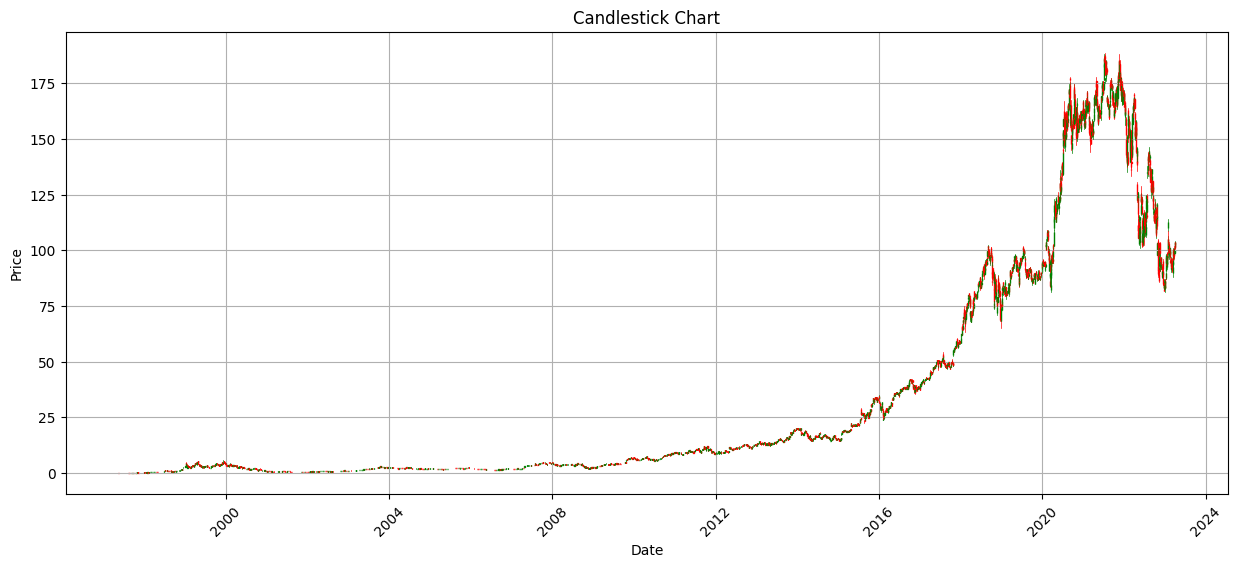

In [6]:
# Convert 'Date' to numeric values
matplotlib_date = mdates.date2num(df['Date'])

# Prepare the OHLC data
ohlc = np.vstack((
    matplotlib_date, 
    df['Open'], 
    df['High'],  # Updated column name
    df['Low'], 
    df['Close']  # Updated column name
)).T

# Plotting the candlestick chart
plt.figure(figsize=(15, 6))
ax = plt.subplot()

candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

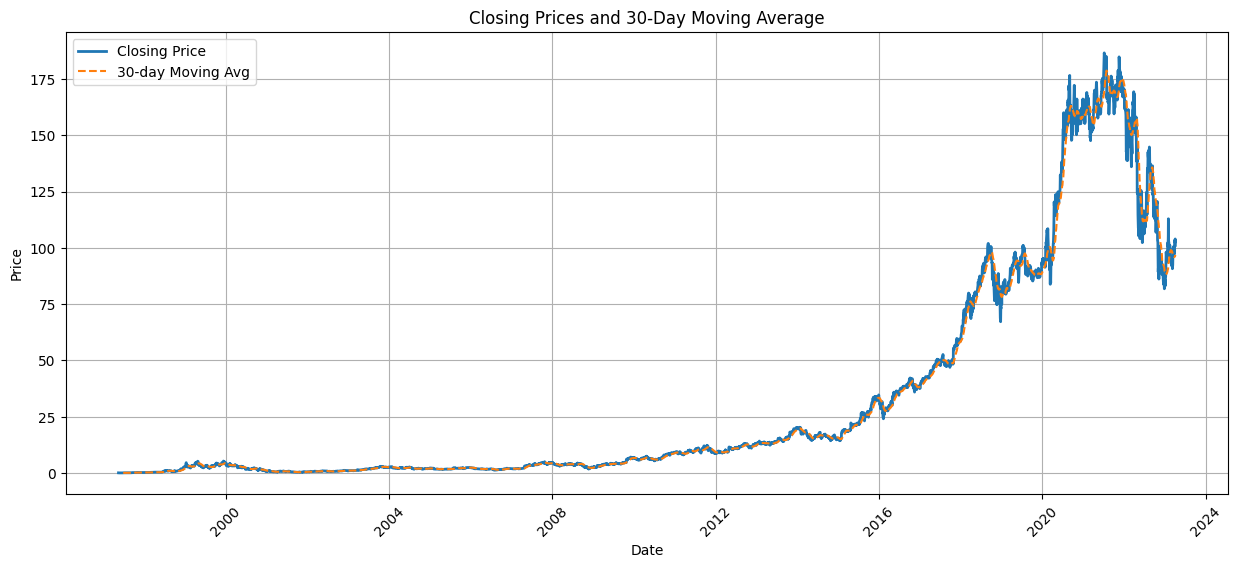

In [7]:
window = 30

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', linewidth=2)

# Fixed missing closing parenthesis and typo
plt.plot(df['Date'], 
         df['Close'].rolling(window=window).mean(), 
         label=f'{window}-day Moving Avg', linestyle='--')

plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


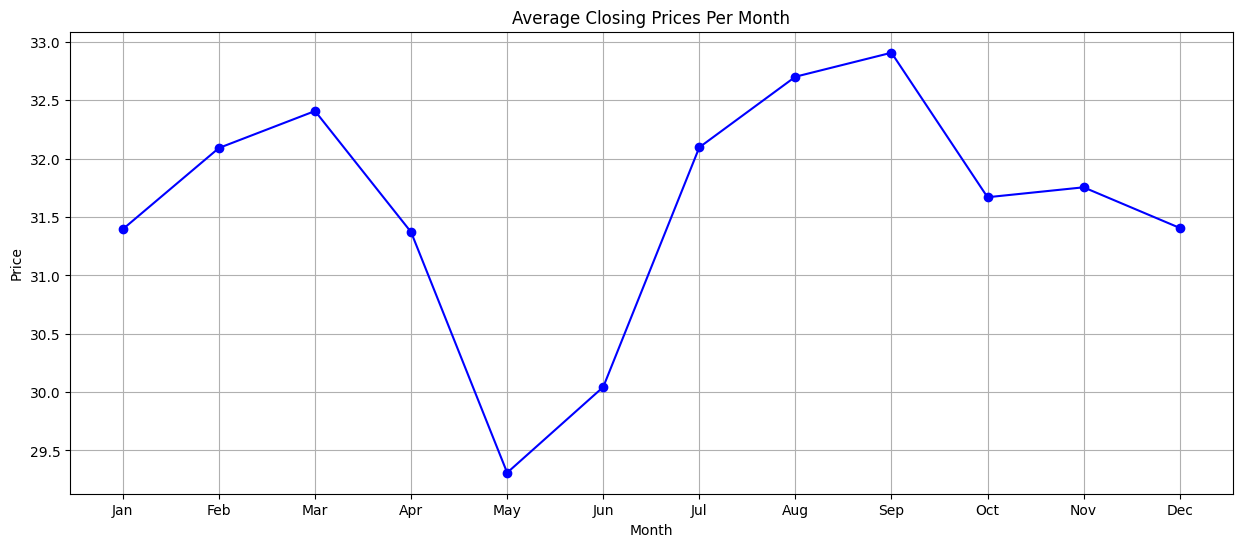

In [8]:
# Extract the month from the Date column
df['Month'] = df['Date'].dt.month

# Group by month and compute the mean closing price
monthly_average = df.groupby('Month')['Close'].mean()  # Updated column name

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o', linestyle='-', color='b')

plt.title('Average Closing Prices Per Month')
plt.xlabel('Month')
plt.ylabel('Price')

# Fix the missing closing parenthesis
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.grid(True)
plt.show()


In [9]:
df.head()

Date      Open      High       Low     Close  Adj Close      Volume  \
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000   
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000   
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000   
3 1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000   
4 1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000   

   Month  
0      5  
1      5  
2      5  
3      5  
4      5

In [10]:
new_df = df.reset_index()['Close']


In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [12]:
train_size = int(len(scaled_data)*0.8)
train_data , test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60 

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i-n_past:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):  
    X_test.append(test_data[i-n_past:i, 0]) 
    y_test.append(test_data[i, 0])  

X_test, y_test = np.array(X_test), np.array(y_test)


In [14]:
print("Training data:")
print(X_train.shape)
print(y_train.shape)

print('\n')

print("Testing set size:")
print(X_test.shape)
print(y_test.shape)

Training data:
(5152, 60)
(5152,)


Testing set size:
(1244, 60)
(1244,)


In [15]:
X_train = X_train.reshape(X_train.shape[0] , X_train.shape[1]  ,1 )
X_test = X_test.reshape(X_test.shape[0] , X_test.shape[1]  ,1 )


In [16]:
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss='mean_squared_error' , optimizer='adam')

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Corrected ModelCheckpoint and EarlyStopping
checkpoints = ModelCheckpoint(filepath='my_weights.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=30,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints, early_stopping])


Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 8.5331e-04 - val_loss: 0.0017
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.1844e-04 - val_loss: 0.0021
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 8.7195e-05 - val_loss: 0.0016
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.2321e-04 - val_loss: 0.0021
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.2512e-05 - val_loss: 0.0015
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.8397e-05 - val_loss: 0.0019
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.6600e-05 - val_loss: 0.0012
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 6.4673e-05 - val_loss: 0.0012
Epoch 9/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 7.0494e-05 - val_loss: 0.0012
Epoch 10/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 6.5472e-05 - val_loss: 0.0015
Epoch 11/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 6.7752e-05 - val_loss: 0.0

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [22]:
print(math.sqrt(mean_squared_error(y_train , train_predict)))
print(math.sqrt(mean_squared_error(y_test , test_predict)))

16.137082517152944
125.18985085074985


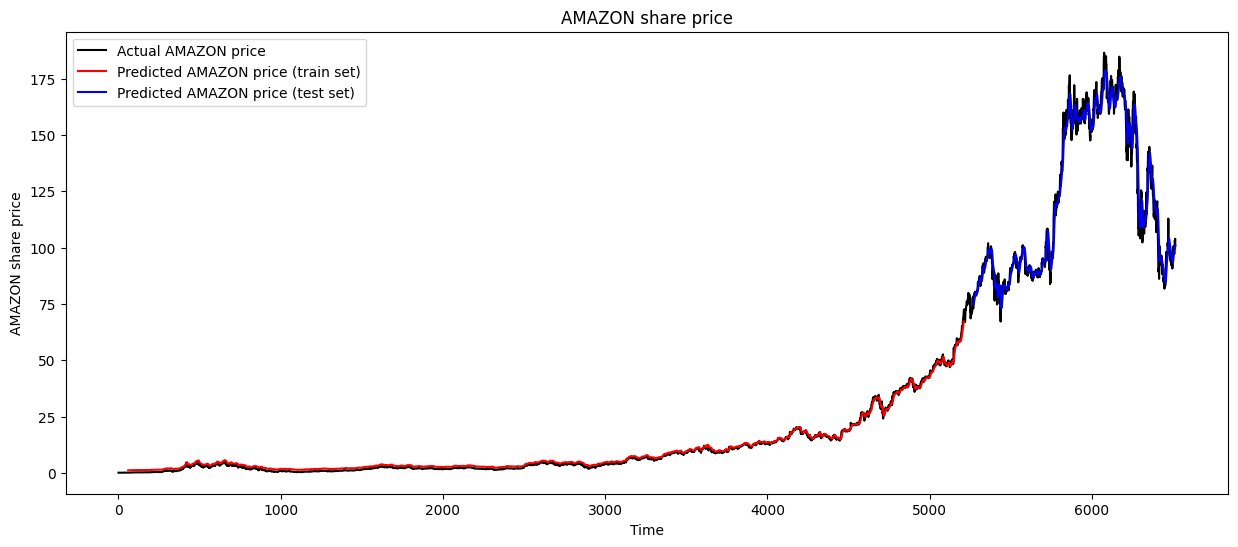

In [23]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
testPredictPlot[len(new_df) - len(test_predict):] = test_predict.flatten()

original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual AMAZON price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted AMAZON price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted AMAZON price (test set)")

plt.title(f"AMAZON share price")
plt.xlabel("Time")
plt.ylabel(f"AMAZON share price")
plt.legend()
plt.show()


In [24]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)  # Make sure last_sequence has the right shape
predictions_next_10_days = []  # Fixed the variable name to match below

for _ in range(10): 
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Roll sequence for next prediction
    last_sequence[0, -1, 0] = next_day_prediction  # Update last sequence with predicted value

predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

print("Prediction for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for the next 10 days:
Day 1: Predicted Price = 100.8372802734375
Day 2: Predicted Price = 101.3602066040039
Day 3: Predicted Price = 101.7344970703125
Day 4: Predicted Price = 101.99120330810547
Day 5: Predicted Price = 102.171142578125
Day 6: Predicted Price = 102.30731201171875
Day 7: Predicted Price = 102.42155456542969
Day 8: Predicted Price = 102.52642059326172
Day 9: Predicted Price = 102.62834930419922
Day 10: Predicted Price = 102.73011779785156


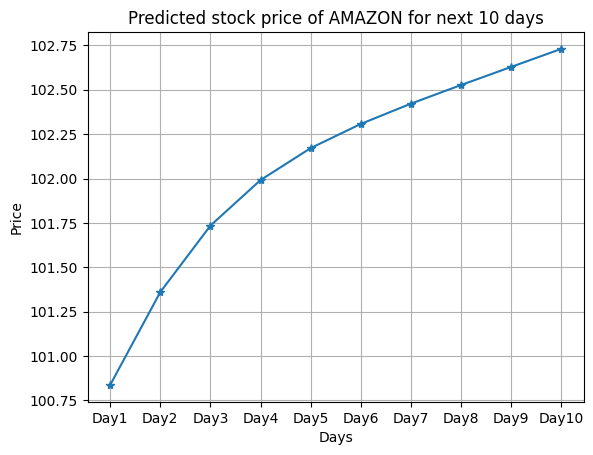

In [25]:
plt.plot(predictions_next_10_days, marker="*")
plt.title(f'Predicted stock price of AMAZON for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()
